# Power Line Assets Detection

In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/ProjectsVerse/plad_project" "/content/plad_project"

Mounted at /gdrive


In [2]:
import os
import json
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from plad_project.utils import (img_to_tensor, scale_bbox, draw_true_boxes,
                   preprocess_true_boxes, load_darknet_weights)

from sklearn.model_selection import train_test_split
import tensorflow as tf
from plad_project.yolov3_arch import YoloV3, YoloLoss
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        TensorBoard, ModelCheckpoint)

In [3]:
# input_shape = (3648, 5472, 3)
input_shape = (1824, 2752, 3)
# input_shape = (416, 416, 3)
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preprocessing

### Images Dataframe

In [5]:
with open(r"/content/plad_project/plad/annotations.json", 'r') as f: #context manager
    annot_json = json.load(f)
type(annot_json) # converted json to dictionary

dict

In [6]:
images = pd.DataFrame(annot_json["images"])
images.set_index('id', inplace=True)
images.head()

,licence,file_name,coco_url,height,width,date_captured,flickr_url
id,,,,,,,
0,0,20181129-R/DJI_0021.JPG,,3648,5472,2019-11-01 00:00:00,
1,0,20181129-R/DJI_0009.JPG,,3648,5472,2019-11-01 00:00:00,
2,0,20181129-R/DJI_0024.JPG,,3648,5472,2019-11-01 00:00:00,
3,0,20181127-A1/DJI_0479.JPG,,3078,5472,2019-11-01 00:00:00,
4,0,20181127-A1/DJI_0460.JPG,,3078,5472,2019-11-01 00:00:00,


In [7]:
images.drop(["coco_url", "flickr_url", "date_captured", "licence"], axis=1, inplace=True)
images.head()

,file_name,height,width
id,,,
0,20181129-R/DJI_0021.JPG,3648,5472
1,20181129-R/DJI_0009.JPG,3648,5472
2,20181129-R/DJI_0024.JPG,3648,5472
3,20181127-A1/DJI_0479.JPG,3078,5472
4,20181127-A1/DJI_0460.JPG,3078,5472


In [8]:
images['img_tensor'] = images['file_name'].apply(lambda x: img_to_tensor(x, input_shape))
# let's leave height and width column unchanged, 
# so that we can track the original dimensions of that image
images.head()

In [9]:
images.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   133 non-null    object
 1   height      133 non-null    int64 
 2   width       133 non-null    int64 
 3   img_tensor  133 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.2+ KB


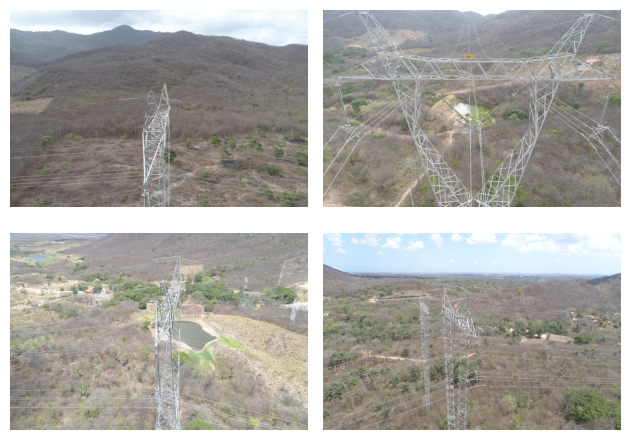

In [10]:
fig, ax = plt.subplots(2,2)
ax[0, 0].imshow(images['img_tensor'][1])
ax[0, 0].axis(False)
ax[0, 1].imshow(images['img_tensor'][2])
ax[0, 1].axis(False)
ax[1, 0].imshow(images['img_tensor'][3])
ax[1, 0].axis(False)
ax[1, 1].imshow(images['img_tensor'][4])
ax[1, 1].axis(False)
plt.tight_layout()

### Annotations Dataframe

In [11]:
annot = pd.DataFrame(annot_json['annotations'])
annot.set_index('id', inplace=True)
annot.head()

,segmentation,area,iscrowd,image_id,bbox,category_id
id,,,,,,
0,[],4838752,0,0,"[2374, 250, 1424, 3398]",0
1,[],33600,0,0,"[1564, 1380, 80, 420]",0
2,[],103440,0,0,"[3684, 1479, 120, 862]",1
3,[],29120,0,0,"[2768, 1395, 56, 520]",1
4,[],17020,0,0,"[2371, 1362, 46, 370]",1


In [12]:
annot.drop(["segmentation", "iscrowd"], inplace=True, axis=1)
annot.head()

,area,image_id,bbox,category_id
id,,,,
0,4838752,0,"[2374, 250, 1424, 3398]",0
1,33600,0,"[1564, 1380, 80, 420]",0
2,103440,0,"[3684, 1479, 120, 862]",1
3,29120,0,"[2768, 1395, 56, 520]",1
4,17020,0,"[2371, 1362, 46, 370]",1


In [13]:
annot1 = np.array(pd.DataFrame(annot['bbox'].tolist()))
# xmin, ymin, w, h --> xmin, ymin, xmax, ymax
annot['bbox'] = list(np.array((annot1[:, 0], annot1[:, 1], 
                          np.add(annot1[:, 0], annot1[:, 2]), 
                          np.add(annot1[:, 1], annot1[:, 3])), dtype=np.int32).T)
annot['bbox'] = annot['bbox'].apply(np.array)
del annot1
annot.head()

,area,image_id,bbox,category_id
id,,,,
0,4838752,0,"[2374, 250, 3798, 3648]",0
1,33600,0,"[1564, 1380, 1644, 1800]",0
2,103440,0,"[3684, 1479, 3804, 2341]",1
3,29120,0,"[2768, 1395, 2824, 1915]",1
4,17020,0,"[2371, 1362, 2417, 1732]",1


In [14]:
lookup = dict()
for i in annot_json['categories']:
    lookup[i['id']] = i['name']
lookup

{0: 'tower', 1: 'insulator', 2: 'spacer', 3: 'damper', 5: 'plate'}

In [15]:
# to maintain the consistency change (5 -> plate) to (4-> plate)
lookup[4] = lookup[5]
del lookup[5]
lookup

{0: 'tower', 1: 'insulator', 2: 'spacer', 3: 'damper', 4: 'plate'}

In [16]:
annot['category_id'].value_counts()

3    1505
1     312
0     253
2     253
5      86
Name: category_id, dtype: int64

In [17]:
annot["category_id"] = annot['category_id'].replace(5, 4)
annot["category_id"].value_counts()

3    1505
1     312
0     253
2     253
4      86
Name: category_id, dtype: int64

In [18]:
annot['bbox_and_cls'] = annot.apply(lambda x: np.hstack((x['bbox'], \
                                                         x['category_id'])), axis=1)
annot.drop(['bbox', 'category_id'], axis=1, inplace=True)
annot.head()

,area,image_id,bbox_and_cls
id,,,
0,4838752,0,"[2374, 250, 3798, 3648, 0]"
1,33600,0,"[1564, 1380, 1644, 1800, 0]"
2,103440,0,"[3684, 1479, 3804, 2341, 1]"
3,29120,0,"[2768, 1395, 2824, 1915, 1]"
4,17020,0,"[2371, 1362, 2417, 1732, 1]"


In [19]:
df = annot.groupby('image_id')['bbox_and_cls'].apply(np.vstack).reset_index(name='bboxes')
annot = pd.DataFrame(df)
annot.head()

,image_id,bboxes
0,0,"[[2374, 250, 3798, 3648, 0], [1564, 1380, 1644..."
1,1,"[[2426, 1358, 2946, 3648, 0], [2414, 3369, 254..."
2,2,"[[146, 10, 5389, 3648, 0], [210, 1378, 502, 21..."
3,3,"[[2638, 385, 3166, 3078, 0], [2641, 1860, 2733..."
4,4,"[[1762, 921, 1990, 2837, 0], [2166, 841, 2846,..."


In [20]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  133 non-null    int64 
 1   bboxes    133 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### PLAD final (combined) dataframe

In [21]:
plad_df = pd.concat([images, annot], axis=1)
plad_df.set_index('image_id', inplace=True)
# apply the scaling function to the 'bbox' column
plad_df['bboxes'] = plad_df.apply(lambda x: scale_bbox(x, input_shape), axis=1)
plad_df.head()

In [22]:
del images
del annot

20181129-R DJI_0024 saved!!!
20181127-A1 DJI_0479 saved!!!
20181127-A1 DJI_0460 saved!!!
20181127-A1 DJI_0437 saved!!!



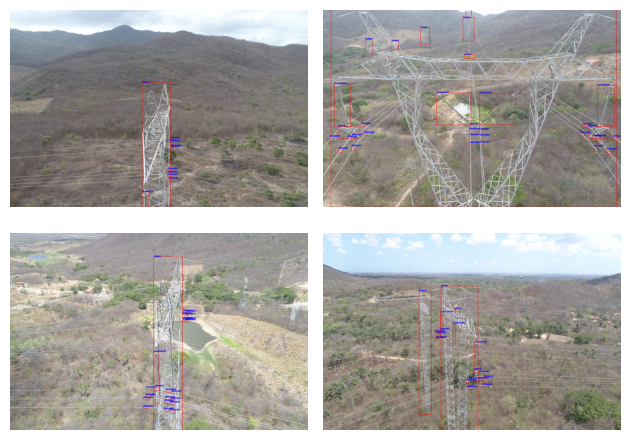

In [23]:
some_annotated_true_images = []

for i in range(1, 5):
    temp = draw_true_boxes(plad_df['img_tensor'][i], 
                            plad_df['bboxes'][i], lookup)
    name = (plad_df['file_name'][i+1][:-4]).split('/')
    name = " ".join(name)
    print(name, "saved!!!")
    cv2.imwrite("/content/plad_project/true_labelled/{}.jpg".format(name), 
            cv2.cvtColor(temp, cv2.COLOR_RGB2BGR))
    some_annotated_true_images.append(temp)

print()
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(some_annotated_true_images[0])
ax[0, 0].axis(False)
ax[0, 1].imshow(some_annotated_true_images[1])
ax[0, 1].axis(False)
ax[1, 0].imshow(some_annotated_true_images[2])
ax[1, 0].axis(False)
ax[1, 1].imshow(some_annotated_true_images[3])
ax[1, 1].axis(False)
del some_annotated_true_images
plt.tight_layout()

In [24]:
plad_df['preprocessed_bboxes'] = plad_df.apply(lambda x: \
                                               preprocess_true_boxes(x['bboxes'],
                                                                     anchors=yolo_anchors,
                                                                     input_shape=input_shape[:2],
                                                                     anchor_mask=yolo_anchor_masks),axis=1)

In [25]:
plad_df.head()

In [26]:
plad_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_name            133 non-null    object
 1   height               133 non-null    int64 
 2   width                133 non-null    int64 
 3   img_tensor           133 non-null    object
 4   bboxes               133 non-null    object
 5   preprocessed_bboxes  133 non-null    object
dtypes: int64(2), object(4)
memory usage: 11.3+ KB


In [27]:
X = (plad_df['img_tensor'][:2]/255).to_list()
y = plad_df['preprocessed_bboxes'][:2].to_list()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=56)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=156)
X_train, X_val = X[0], X[1]
y_train, y_val = y[0], y[1]
del X
del y

In [28]:
print("no. of training samples:", len(X_train))
print("no. of validation samples:", len(X_val))
# print("no. of test samples:", len(X_test))
# del X_test
# del y_test

no. of training samples: 1824
no. of validation samples: 1824


In [33]:
X_train = tf.convert_to_tensor(X_train)

In [34]:
X_val = tf.convert_to_tensor(X_val)

In [ ]:
# for multiple examples: 

In [29]:
# df_ytrain = pd.DataFrame(y_train, columns=['y0', 'y1', 'y2'])
# df_yval = pd.DataFrame(y_val, columns=['y0', 'y1', 'y2'])

In [30]:
# y0_train = df_ytrain['y0'].to_list()
# y1_train = df_ytrain['y1'].to_list()
# y2_train = df_ytrain['y2'].to_list()

In [31]:
# y0_val = df_yval['y0'].to_list()
# y1_val = df_yval['y1'].to_list()
# y2_val = df_yval['y2'].to_list()

In [32]:
# del df_ytrain
# del df_yval

In [35]:
# y0_train = tf.convert_to_tensor(y0_train)
# y1_train = tf.convert_to_tensor(y1_train)
# y2_train = tf.convert_to_tensor(y2_train)


In [36]:
# y0_val = tf.convert_to_tensor(y0_val)
# y1_val = tf.convert_to_tensor(y1_val)
# y2_val = tf.convert_to_tensor(y2_val)


In [ ]:
# for single example: 

In [ ]:
y0_train = tf.convert_to_tensor(y_train[0])
y1_train = tf.convert_to_tensor(y_train[1])
y2_train = tf.convert_to_tensor(y_train[2])

In [ ]:
y0_val = tf.convert_to_tensor(y_val[0])
y1_val = tf.convert_to_tensor(y_val[1])
y2_val = tf.convert_to_tensor(y_val[2])

In [37]:
yolo = YoloV3(input_shape=input_shape, classes=len(lookup), 
              anchors=yolo_anchors, masks=yolo_anchor_masks, training=True)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1824, 2752,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, 228, 344, 2  40620640    ['input[0][0]']                  
                                56),                                                              
                                 (None, 114, 172, 5                                               
                                12),                                                              
                                 (None, 57, 86, 102                                          

In [38]:
load_darknet_weights(model=yolo, weights_file="/content/plad_project/yolov3.weights")

weights loaded successfully.


In [39]:
optimizer = tf.keras.optimizers.Adam()
loss = [YoloLoss(yolo_anchors[mask], classes=len(lookup))
            for mask in yolo_anchor_masks]

In [40]:
yolo.compile(optimizer=optimizer, loss=loss)

In [41]:
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
checkpoints_cb = ModelCheckpoint("/content/plad_project/yolov3_trained_on_plad_vir.h5", save_best_only=True,
                                 save_weights_only=True, verbose=1)
reducee_lr_cb = ReduceLROnPlateau(patience=3, verbose=1)
# TensorBoard Support
# tensorboard --logdir=./my_logs_vir --port=5050
root_logdir = os.path.join(os.curdir, "my_logs_vir")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-#H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()
tensorboard_cb = TensorBoard(run_logdir)
callbackss = [checkpoints_cb, reducee_lr_cb, early_stopping_cb, tensorboard_cb]

In [42]:
# %load_ext tensorboard
# %tensorboard --logdir my_logs_vir

In [43]:
X_train = tf.expand_dims(X_train, 0)
X_val = tf.expand_dims(X_val, 0)
y0_train = tf.expand_dims(y0_train, 0)
y1_train = tf.expand_dims(y1_train, 0)
y2_train = tf.expand_dims(y2_train, 0)
y0_val = tf.expand_dims(y0_val, 0)
y1_val = tf.expand_dims(y1_val, 0)
y2_val = tf.expand_dims(y2_val, 0)

In [44]:
history = yolo.fit(X_train, (y0_train, y1_train, y2_train), epochs=20,
         validation_data=(X_val, (y0_val, y1_val, y2_val)), batch_size=1, callbacks=callbackss)


Epoch 1/20


Instructions for updating:
Use fn_output_signature instead


ResourceExhaustedError: ignored